## NLU Clustering
#### This notebook contain the clustering technque for the 1000 labels of the imagenet dataset

In [1]:
# import libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn import cluster
from sklearn.decomposition import PCA
from gensim import models

plt.style.use("ggplot")

In [2]:
# Loading the csvs

val = pd.read_csv(r"/mnt/c/Users/pietr/Desktop/ImageNet/LOC_val_solution.csv")
train = pd.read_csv(r"/mnt/c/Users/pietr/Desktop/ImageNet/LOC_train_solution.csv")
categ = pd.read_fwf(r"/mnt/c/Users/pietr/Desktop/ImageNet/LOC_synset_mapping.txt")
categ.columns = ["FolderName", "Categories"]

print(val[:5])
print()
print(categ[:5])

                   ImageId                                   PredictionString
0  ILSVRC2012_val_00048981                            n03995372 85 1 499 272 
1  ILSVRC2012_val_00037956                           n03481172 131 0 499 254 
2  ILSVRC2012_val_00026161                            n02108000 38 0 464 280 
3  ILSVRC2012_val_00026171                            n03109150 0 14 216 299 
4  ILSVRC2012_val_00008726  n02119789 255 142 454 329 n02119789 44 21 322 ...

  FolderName                                         Categories
0  n01443537                        goldfish, Carassius auratus
1  n01484850  great white shark, white shark, man-eater, man...
2  n01491361                    tiger shark, Galeocerdo cuvieri
3  n01494475                       hammerhead, hammerhead shark
4  n01496331         electric ray, crampfish, numbfish, torpedo


In [3]:
# Loading the models

os.chdir(r"/mnt/c/Users/pietr/Thesis/models/")

# model trained on google news
google_model = models.KeyedVectors.load_word2vec_format(
    "googlenews_word2vec/GoogleNews-vectors-negative300.bin", binary=True
)

# model trained on wikipedia corpuses
wiki_model = models.KeyedVectors.load_word2vec_format(
    "wikipedia_word2vec_model/model.bin", binary=True
)

### Label Clustering 


In [4]:
categ = pd.read_fwf(r"/mnt/c/Users/pietr/Desktop/ImageNet/LOC_synset_mapping.txt")
categ.columns = ["FolderName", "Categories"]


def remove_dupl(x):
    """
    Method to remove duplicates in categories (preprocess2("shark shark") becomes "shark")
    """
    x = x.split()
    x = " ".join(sorted(set(x), key=x.index))
    return x


def clean_categ(x):
    """
    Method to keep only last word in categories ("tiger shark, Galeocerdo cuvieri" becomes "shark cuvieri")
    """
    x = x.split(",")  # split every category name
    x1 = ""
    for i in x:
        for j in i.split()[-1:]:  # keep only last word for each name
            x1 += j
            x1 += " "
    x = remove_dupl(x1.lower().replace("-", ""))
    return x


categ["Categories"] = categ["Categories"].apply(clean_categ)
print(categ[:3])

  FolderName                 Categories
0  n01443537           goldfish auratus
1  n01484850  shark maneater carcharias
2  n01491361              shark cuvieri


In [17]:
# retrieve vectors from word2vec google news

vectors = []

for i in categ["Categories"]:
    arrays = []
    for j in i.split():
        j = j.replace(",", "")
        if j in google_model.key_to_index.keys():
            arrays.append(list(google_model.get_vector(j)))
    vectors.append(np.sum(arrays, axis=0) / len(arrays))

vectors = pd.Series(vectors, name="Vectors")
categ2 = pd.concat([categ, vectors], axis=1)
categ2 = categ2.dropna().reset_index()
print("total labels clustered from google news:", len(categ2))

categ2_google = categ2

total labels clustered from google news: 973


/tmp/ipykernel_722/1617477782.py:11: RuntimeWarning: invalid value encountered in double_scalars
  vectors.append(np.sum(arrays, axis=0) / len(arrays))


In [18]:
# retrieve vectors from word2vec wikipedia

words = wiki_model.key_to_index.keys()

split_under = lambda x: [i.split("_")[0] for i in x]
lst_words = split_under(words)
vectors = []

for word in words:
    categ_lst = list(categ["Categories"])
    if word.split("_")[0] in categ_lst:
        vectors.append(wiki_model.get_vector(word))

vectors = pd.Series(vectors, name="Vectors")
categ2 = pd.concat([categ, vectors], axis=1)
categ2 = categ2.dropna().reset_index()
print("total labels clustered from wikipedia:", len(categ2))
wiki_method1_categ = categ2

total labels clustered from wikipedia: 999


In [7]:
# joining the vectors from word2vec google news and word2vec wikipedia

wiki_method1_categ = wiki_method1_categ.set_index("index")
categ2_google = categ2_google.set_index("index")


for i in wiki_method1_categ.index:
    if i not in categ2_google.index:
      # print(i)  # printing labels not included in google news model
        categ2_google = pd.concat(
            [categ2_google, wiki_method1_categ.loc[wiki_method1_categ.index == i]]
        )

categ2 = categ2_google.sort_index()
print(categ2[:3])

      FolderName                 Categories  \
index                                         
0      n01443537           goldfish auratus   
1      n01484850  shark maneater carcharias   
2      n01491361              shark cuvieri   

                                                 Vectors  
index                                                     
0      [-0.080078125, 0.33203125, 0.110839844, 0.2480...  
1      [-0.03108724, 0.067464195, -0.1719157, -0.0725...  
2      [-0.048828125, 0.049804688, -0.328125, -0.1225...  


In [8]:
# create dataframe with only vector representation to fit to the KMeans

df = pd.DataFrame(list(categ2["Vectors"]), columns=range(0, 300), dtype=float)
print(df[:3])

        0         1         2         3         4         5         6    \
0 -0.080078  0.332031  0.110840  0.248047 -0.168945  0.119629 -0.039307   
1 -0.031087  0.067464 -0.171916 -0.072591 -0.042236  0.156413 -0.137126   
2 -0.048828  0.049805 -0.328125 -0.122559 -0.121094  0.058594 -0.218750   

        7         8         9    ...       290       291       292       293  \
0  0.049561 -0.185547  0.160156  ... -0.163086  0.040283 -0.149414 -0.159180   
1 -0.001010  0.064290  0.068542  ...  0.067698 -0.033773 -0.129395 -0.083008   
2  0.123535  0.425781 -0.002991  ... -0.016724 -0.142578 -0.129883 -0.079590   

        294       295       296       297       298       299  
0 -0.048096 -0.210938  0.076172  0.086426 -0.237305 -0.231445  
1 -0.064097 -0.001628  0.050735  0.104335 -0.081136  0.055623  
2  0.004974  0.113770  0.211914  0.212891 -0.296875 -0.078613  

[3 rows x 300 columns]


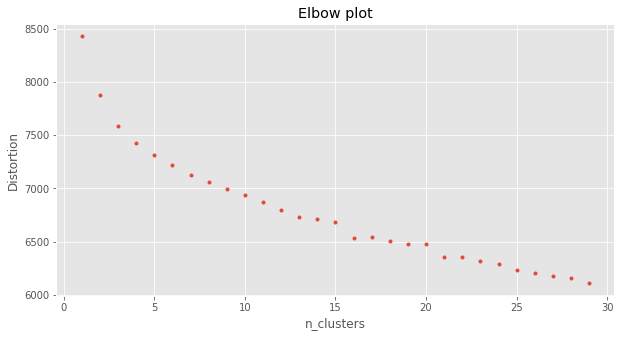

For n_clusters = 2 The average silhouette_score is : 0.5674003087470016
For n_clusters = 3 The average silhouette_score is : 0.6188074944702807
For n_clusters = 4 The average silhouette_score is : 0.4384951913914001
For n_clusters = 5 The average silhouette_score is : 0.4222085711758885


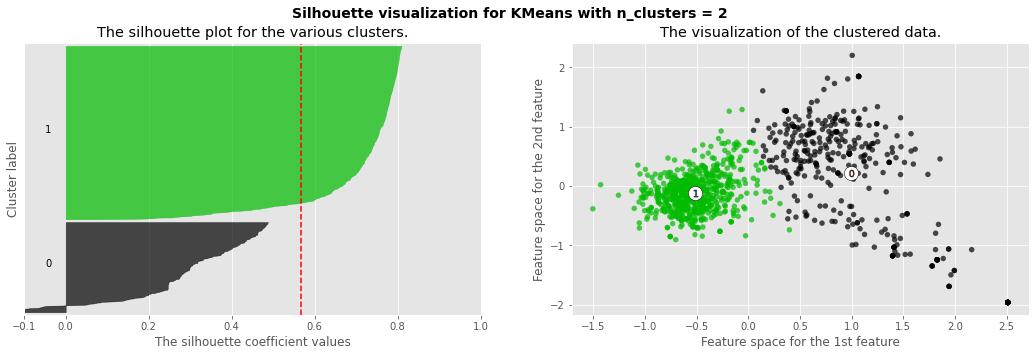

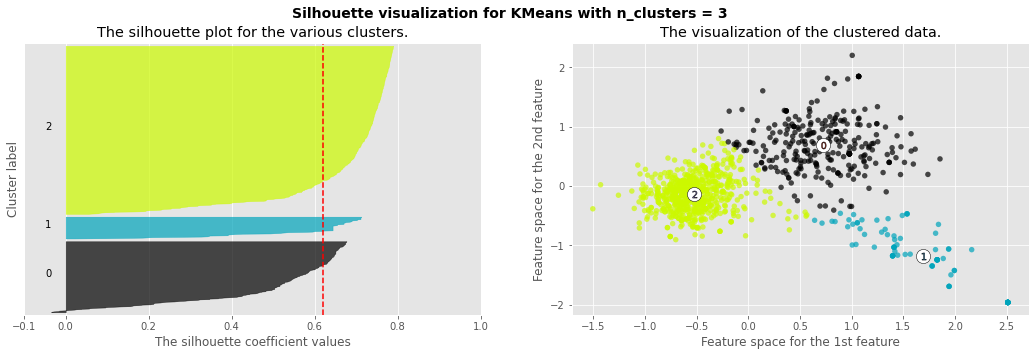

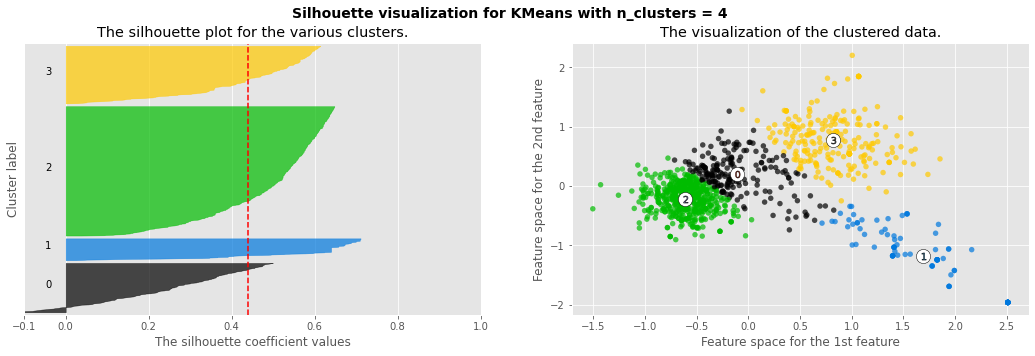

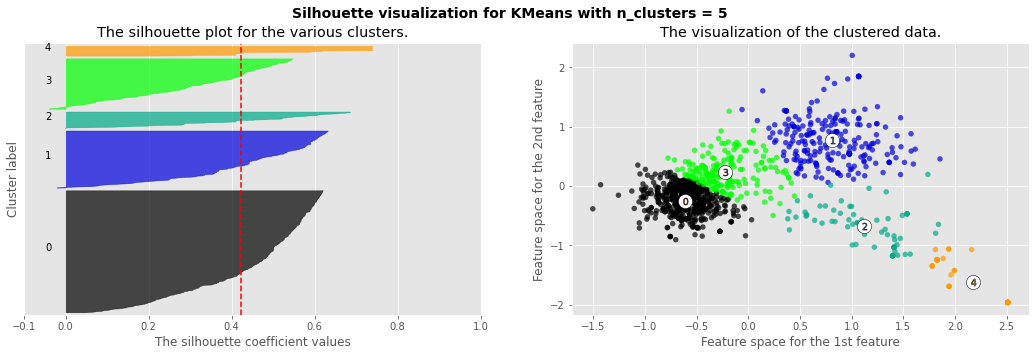

In [10]:
# visualize the elbowplot to estimate the ideal number of clusters

distortions = []
K = range(1, 30)
for k in K:
    kmeanModel = cluster.KMeans(n_clusters=k)
    kmeanModel.fit(df)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(K, distortions, ".")
plt.xlabel("n_clusters")
plt.ylabel("Distortion")
plt.title("Elbow plot")
plt.show()

pca = PCA(2)
df_pca = pca.fit_transform(df) # reduce vector to 2 dimensions

# code from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

for n_clusters in [2, 3, 4, 5]:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df_pca)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_pca, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        df_pca[:, 0],
        df_pca[:, 1],
        marker="o",
        s=30,
        lw=0,
        alpha=0.7,
        c=colors,
        edgecolor="k",
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette visualization for KMeans with n_clusters = %d" % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Clustering dataset's id labels
number of clustered labels:  999
labels:  [1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 1 0 1 1 1 1 1 1
 1 1 2 2 2 0 0 2 2 2 1 0 2 2 2 0 2 2 1 0 1 2 2 2 2 0 2 1 0 0 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 0 0 0 0 0 2 2 2 2 2 2 2 0
 0 0 0 0 2 0 2 2 2 2 0 2 2 2 0 2 2 0 0 0 2 2 2 0 0 2 2 2 2 2 1 2 0 2 0 0 2
 0 0 1 2 2 2 2 2 1 1 1 1 1 1 0 2 1 1 1 1 1 2 2 2 1 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 

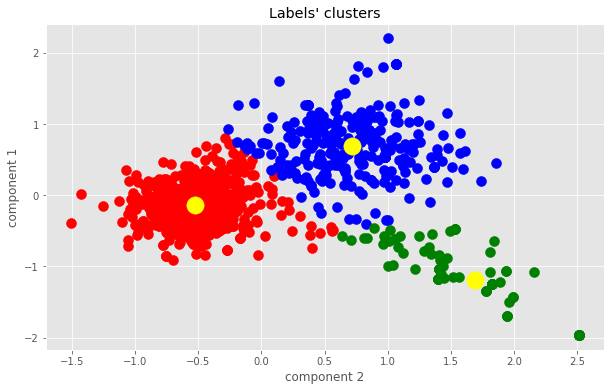

In [11]:
# Cluster the data and visualize the clusters

kmeans2 = cluster.KMeans(n_clusters=3) # define KMeans model to reduced data
y_kmeans = kmeans2.fit_predict(df_pca) 
labels = kmeans2.labels_
centroids = kmeans2.cluster_centers_

print("Clustering dataset's id labels")
print("number of clustered labels: ", len(labels))
print("labels: ", labels)

domains = pd.Series(labels, name="Cluster")


final = pd.concat([categ2, domains], axis=1)  # concatenating the domain to the dataset
print(final[:3])

plt.figure(figsize=(10, 6))

plt.scatter(
    df_pca[y_kmeans == 0, 0],
    df_pca[y_kmeans == 0, 1],
    s=100,
    c="red",
    label="Cluster 1",
)
plt.scatter(
    df_pca[y_kmeans == 1, 0],
    df_pca[y_kmeans == 1, 1],
    s=100,
    c="blue",
    label="Cluster 2",
)
plt.scatter(
    df_pca[y_kmeans == 2, 0],
    df_pca[y_kmeans == 2, 1],
    s=100,
    c="green",
    label="Cluster 3",
)
plt.scatter(
    df_pca[y_kmeans == 3, 0],
    df_pca[y_kmeans == 3, 1],
    s=100,
    c="cyan",
    label="Cluster 4",
)
plt.scatter(
    df_pca[y_kmeans == 4, 0],
    df_pca[y_kmeans == 4, 1],
    s=100,
    c="brown",
    label="Cluster 5",
)

# Plot the centroid. This time we're going to use the cluster centres  #attribute that returns here the coordinates of the centroid.
plt.scatter(
    kmeans2.cluster_centers_[:, 0],
    kmeans2.cluster_centers_[:, 1],
    s=300,
    c="yellow",
    label="Centroids",
)
plt.title("Labels' clusters")

plt.ylabel("component 1")
plt.xlabel("component 2")
plt.show()

In [12]:
# Preprocess 'PredictionString' to retrieve category

val["PredictionCode"] = val["PredictionString"].apply(lambda x: x.split()[0])
print(val[:3])

                   ImageId          PredictionString PredictionCode
0  ILSVRC2012_val_00048981   n03995372 85 1 499 272       n03995372
1  ILSVRC2012_val_00037956  n03481172 131 0 499 254       n03481172
2  ILSVRC2012_val_00026161   n02108000 38 0 464 280       n02108000


In [13]:
# Merging the validation set data to the final dataset to have the cluster on the validation images

val2 = val.merge(
    final[["Cluster", "FolderName", "Categories"]],
    left_on="PredictionCode",
    right_on="FolderName",
)

val2 = val2.drop(["PredictionCode", "PredictionString"], axis=1)
val2 = val2.sample(frac=1).reset_index()

print(val2[:3])
print(len(val2))
os.chdir(r"/mnt/c/Users/pietr/Desktop/ImageNet/")

#val2.to_csv("validation2.csv")

   index                  ImageId  Cluster FolderName       Categories
0  38857  ILSVRC2012_val_00015774        2  n02097298  terrier scottie
1  18477  ILSVRC2012_val_00049325        0  n07584110         consomme
2  32025  ILSVRC2012_val_00014430        2  n02110341    dalmatian dog
49950


ILSVRC2012_val_00049325
Cluster:  0
Category:  consomme
ILSVRC2012_val_00008260
Cluster:  0
Category:  bar
ILSVRC2012_val_00008763
Cluster:  0
Category:  center
ILSVRC2012_val_00038932
Cluster:  0
Category:  aid
ILSVRC2012_val_00048068
Cluster:  0
Category:  widow mactans
ILSVRC2012_val_00033357
Cluster:  0
Category:  leonberg


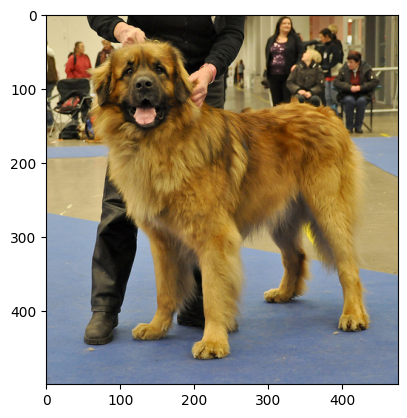


ILSVRC2012_val_00000782
Cluster:  0
Category:  sauce syrup
ILSVRC2012_val_00045213
Cluster:  0
Category:  cuirass
ILSVRC2012_val_00031052
Cluster:  0
Category:  barrow cart wheelbarrow
ILSVRC2012_val_00004818
Cluster:  0
Category:  entlebucher
ILSVRC2012_val_00031082
Cluster:  0
Category:  cote cot
ILSVRC2012_val_00038049
Cluster:  0
Category:  pickup truck
ILSVRC2012_val_00033795
Cluster:  0
Category:  coffeepot


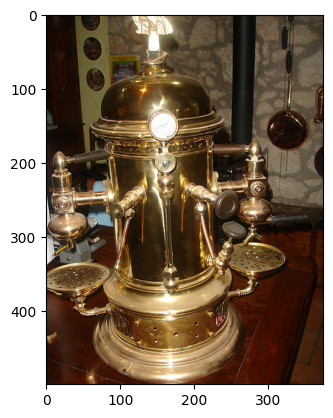


ILSVRC2012_val_00045411
Cluster:  0
Category:  box case
ILSVRC2012_val_00038840
Cluster:  0
Category:  refrigerator icebox
ILSVRC2012_val_00006845
Cluster:  0
Category:  doormat mat
ILSVRC2012_val_00040110
Cluster:  0
Category:  clog geta patten sabot
ILSVRC2012_val_00019940
Cluster:  0
Category:  drum
ILSVRC2012_val_00041125
Cluster:  0
Category:  snowmobile
ILSVRC2012_val_00044601
Cluster:  0
Category:  iron
ILSVRC2012_val_00045276
Cluster:  0
Category:  carrier flattop
ILSVRC2012_val_00009575
Cluster:  0
Category:  beaker
ILSVRC2012_val_00014034
Cluster:  0
Category:  bookcase
ILSVRC2012_val_00013055
Cluster:  0
Category:  rifle
ILSVRC2012_val_00045473
Cluster:  0
Category:  keyboard keypad


In [14]:
# visualize sample images belonging to cluster 0
plt.style.use('default')

os.chdir(r"/mnt/c/Users/pietr/Desktop/ImageNet/DATA/testing/val252_1")
for i, URL in enumerate(val2["ImageId"][:40]):
    if val2["Cluster"][i] == 0:
        try:
            image_name = "{}.JPEG".format(URL)
            category = str(val2["FolderName"][i]).split()[0]
            print(URL)
            print("Cluster: ", val2["Cluster"][i])
            print("Category: ", val2["Categories"][i])
            img = mpimg.imread(image_name)
            imgplot = plt.imshow(img)
            plt.show()
            print()
        except FileNotFoundError:
            pass

ILSVRC2012_val_00028625
Cluster:  1
Category:  pig cobaya
ILSVRC2012_val_00043951
Cluster:  1
Category:  bullfrog catesbeiana
ILSVRC2012_val_00040556
Cluster:  1
Category:  hairless
ILSVRC2012_val_00022025
Cluster:  1
Category:  cock


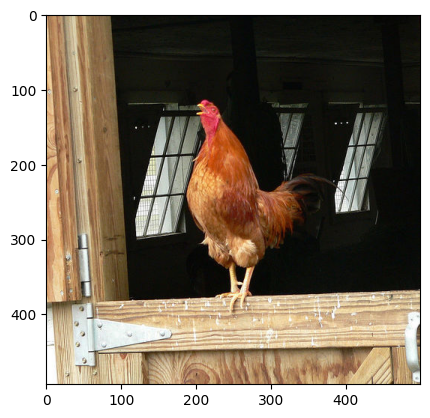


ILSVRC2012_val_00043580
Cluster:  1
Category:  foxhound
ILSVRC2012_val_00015606
Cluster:  1
Category:  leafhopper


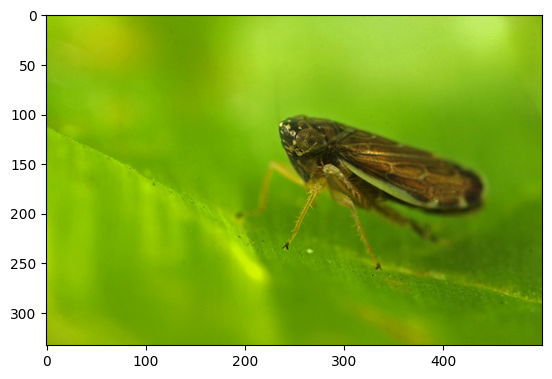


ILSVRC2012_val_00001721
Cluster:  1
Category:  skunk polecat pussy
ILSVRC2012_val_00032712
Cluster:  1
Category:  leopard ounce uncia


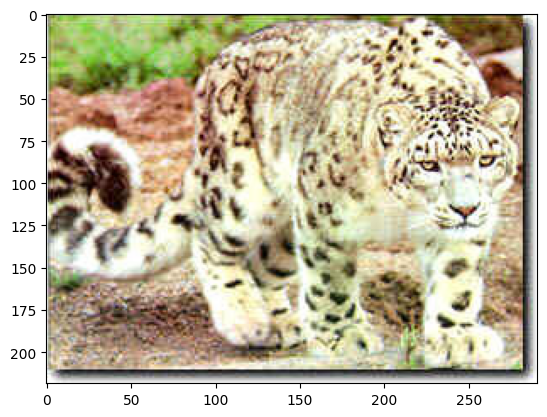


ILSVRC2012_val_00040233
Cluster:  1
Category:  koala bear cinereus


In [15]:
# visualize sample images belonging to cluster 1

for i, URL in enumerate(val2["ImageId"][:40]):
    if val2["Cluster"][i] == 1:
        try:
            image_name = "{}.JPEG".format(URL)
            category = str(val2["FolderName"][i]).split()[0]
            print(URL)
            print("Cluster: ", val2["Cluster"][i])
            print("Category: ", val2["Categories"][i])
            img = mpimg.imread(image_name)
            imgplot = plt.imshow(img)
            plt.show()
            print()
        except FileNotFoundError:
            pass

ILSVRC2012_val_00015774
Cluster:  2
Category:  terrier scottie


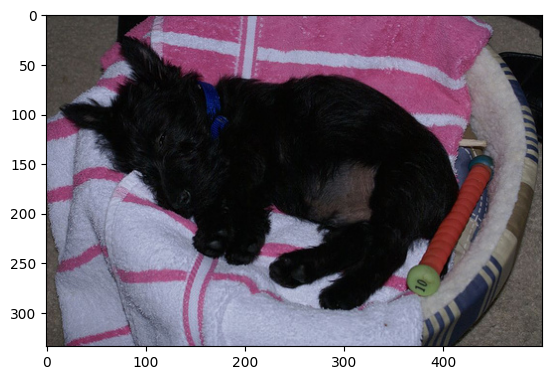


ILSVRC2012_val_00014430
Cluster:  2
Category:  dalmatian dog


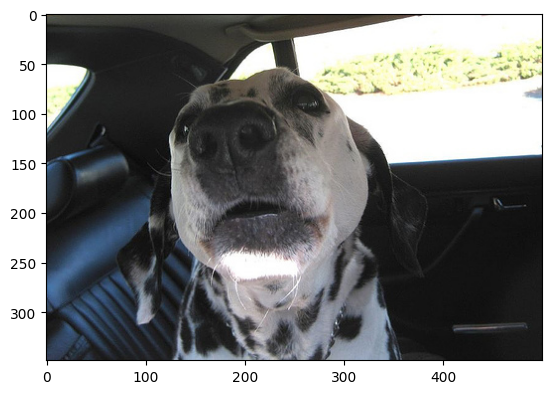


ILSVRC2012_val_00012364
Cluster:  2
Category:  terrier scottie


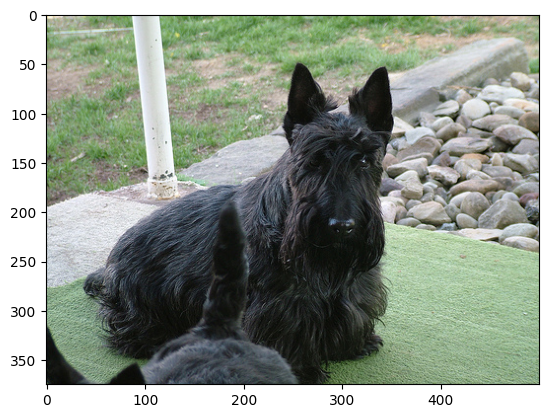

In [20]:
# visualize sample images belonging to cluster 2

for i, URL in enumerate(val2["ImageId"][:15]):
    if val2["Cluster"][i] == 2:
        try:
            image_name = "{}.JPEG".format(URL)
            category = str(val2["FolderName"][i]).split()[0]
            print(URL)
            print("Cluster: ", val2["Cluster"][i])
            print("Category: ", val2["Categories"][i])
            img = mpimg.imread(image_name)
            imgplot = plt.imshow(img)
            plt.show()
            print()
        except FileNotFoundError:
            pass